---
title: "Bayesian A/B Testing — PyMC examples, HDI, and Safe Stopping"
author: "Nikita Podlozhniy"
summary: "Practical guide: PyMC examples, hierarchical models, loss functions, HDI, and safe Bayesian stopping rules."
date: "2025-11-29"
format:
    hugo-md:
jupyter: python3
execute:
    enabled: true
    cache: true
tags:
    - bayesian
    - ab-testing
    - pymc
    - sequential-testing
categories:
    - posts
language: en
draft: false
---

# Bayesian A/B Testing — Practical Recipes

This interactive notebook demonstrates a concise, pragmatic approach to Bayesian A/B testing using PyMC and analytic Beta-Binomial formulas.

What you'll find here:

- A minimal, runnable PyMC example to obtain posterior samples.
- A hierarchical model example for multiple related tests (shrinkage).
- Analytic Beta-Binomial updates and closed-form PoS / Expected Loss expressions.
- A Monte Carlo harness comparing frequentist sequential z-tests and several Bayesian stopping rules.

TL;DR: Posterior summaries (Probability of Superiority, HDI) are great for interpretation — but do not use a raw PoS threshold alone as a stopping rule if you care about long-run Type I error. Prefer decision-theoretic (expected loss) or precision-aware (HDI + PoS) stopping rules.

## A simple A/B test with PyMC

Let's start with the simplest case: two variants (A and B), each observed over a batch of trials, with a binary outcome (e.g., conversion: yes/no).

**Goal**: Use MCMC to draw posterior samples of each variant's success probability, then compute how likely variant A is to outperform variant B.

In [1]:
from pymc import Uniform, Bernoulli

from matplotlib import pyplot as plt

import seaborn as sns

import pandas as pd
import numpy as np

import pymc as pm

### Step 1: Set up imports

Import PyMC, NumPy, and visualization libraries.

In [2]:
a_default, b_default = 0.06, 0.04
a_count, b_count = 200, 150

rng = np.random.default_rng(seed=42)

a_bernoulli_samples = rng.binomial(n=1, p=a_default, size=a_count)
b_bernoulli_samples = rng.binomial(n=1, p=b_default, size=b_count)

### Step 2: Simulate observed data

Generate sample data: two variants with known conversion rates. In practice, these would be your real observed counts from the experiment.

In [3]:
print(f"Pointwise Estimation: A: {a_bernoulli_samples.sum() / a_count :.3f}, B: {b_bernoulli_samples.sum() / b_count :.3f}")

Pointwise Estimation: A: 0.040, B: 0.020


Quick sanity check: plug-in estimates (observed proportions). These will be compared with posterior estimates below.

In [4]:
with pm.Model() as my_model:

    A_prior = Uniform('A_prior', lower=0, upper=1)
    B_prior = Uniform('B_prior', lower=0, upper=1)

    A_observed = Bernoulli('A_observed', p=A_prior, observed=a_bernoulli_samples)
    B_observed = Bernoulli('B_observed', p=B_prior, observed=b_bernoulli_samples)

    delta = pm.Deterministic("delta", A_prior - B_prior)

### Step 3: Define the Bayesian model

We model each variant's success probability as an independent random variable (both with uniform prior, which is weakly informative for a proportion). The observed data (Bernoulli trials) are the likelihood. We also define a *deterministic* variable `delta` to track the difference A − B for downstream analysis.

In [5]:
with my_model:
    idata = pm.sample(draws=5000, tune=1000, cores=-1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [A_prior, B_prior]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


### Step 4: Sample from the posterior

PyMC runs MCMC (specifically, the No-U-Turn Sampler by default) to draw samples from the joint posterior. The `tune` parameter controls burn-in iterations (discarded); `draws` are the kept samples used for inference.

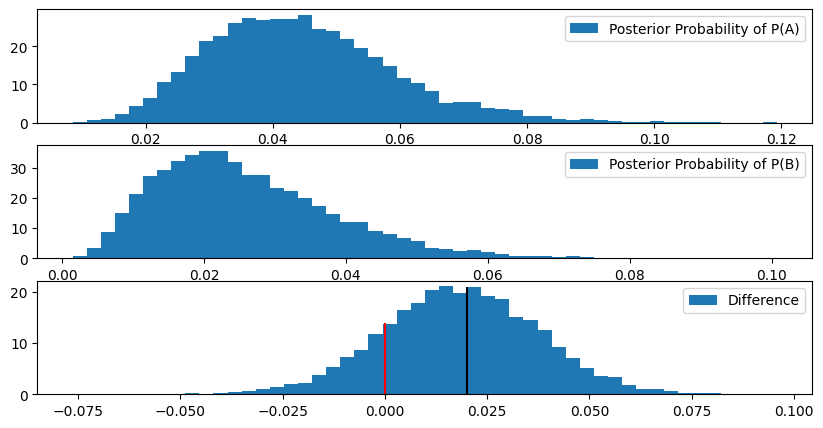

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.hist(idata.posterior['A_prior'].values.ravel(), bins=50, density=True, label="Posterior Probability of P(A)")
plt.legend()

plt.subplot(3, 1, 2)
plt.hist(idata.posterior['B_prior'].values.ravel(), bins=50, density=True, label="Posterior Probability of P(B)")
plt.legend()

plt.subplot(3, 1, 3)
plt.hist(idata.posterior['delta'].values.ravel(), bins=50, density=True, label="Difference")
plt.legend()


plt.vlines(a_default - b_default, 0, 21, 'k')
plt.vlines(0, 0, 14, 'r')
plt.show()

### Step 5: Visualize the posteriors

Plot the marginal posterior distributions of each variant and their difference. The vertical black line shows the true (generating) difference; the red line marks zero (no difference).

In [7]:
print(f"This probability may be use to stop the test P(A > B): {(idata.posterior['delta'].values > 0).mean():.1%}")

This probability may be use to stop the test P(A > B): 83.6%


### Step 6: Compute Probability of Superiority (PoS)

Extract samples and compute the empirical fraction of posterior samples where A > B. This answers: "What is the posterior probability that variant A's true success rate exceeds B's?" Note: this is a descriptive summary; we do *not* recommend using it as a raw stopping threshold without accounting for peeking.

---
## Multiple Hypotheses with Hierarchical Models

When you run many related experiments or compare several variants in the same domain, hierarchical (multilevel) models are a practical way to borrow strength across groups. They reduce variance for small groups (shrinkage) and improve estimation stability. Below is a compact PyMC implementation that models group probabilities as draws from a shared Beta(a, b) prior.

This pattern is useful for dashboarding many A/B results together or for pooling information when sample sizes vary across tests.

#### What is hierarchical models

In a hierarchical (or multilevel) model, you assume that the parameters for each group are related and drawn from a common, overarching distribution. This shared distribution is governed by hyperparameters.

All group-level parameters are drawn from a single, shared distribution defined by hyperparameters a and b. For example each test's probability is drawn from a shared Beta(a,b), where a and b are themselves parameters to be estimated.

The estimate for any single group is influenced both by its own data and the data from all other groups (via the shared a and b). This is called partial pooling, Say a and b are estimated to best fit all test data, and then every test's probability is pulled slightly toward the overall average defined by a and b.

Estimates for small groups are pulled toward the average (a process called shrinkage), leading to more stable, less extreme estimates

#### Which distribution may be used?

Non-Informative Prior for Beta Hyperparameters:
  $$p(a,b) \propto (a+b)^{-5/2}$$

Simplification or approximation of the Jeffreys Prior for the hyperparameters of the Beta distribution, which is used as a conjugate prior for binomial or Bernoulli likelihoods (common in multiple testing models, e.g., estimating the probability of a true null hypothesis)

When $a$ and $b$ are the shape parameters of Beta distribution, the actual Jeffreys Prior is defined by the Fisher Information matrix:

$$p(a,b) \propto \sqrt{\det(\mathbf{I}(a,b))}$$

The determinant of the Fisher Information matrix for the Beta distribution's parameters is a complex function involving the trigamma function ($\psi'$). Specifically, a known simplification used in some computational Bayesian contexts is related to the mean and total effective count of the Beta distribution.

The term $\tau = a+b$ is often interpreted as the total effective sample size (or precision) of the Beta distribution. The exponent $-5/2$ is a specific value that results from one of the approximations designed to make the prior less influential on the posterior, often for the standard deviation or variance of the underlying distribution.

#### Example

In [8]:
# --- 1. Data Definition ---
trials = np.array([842, 854, 862, 821, 839])
successes = np.array([27, 47, 69, 52, 35])

N_GROUPS = len(trials)
# Constraint for Beta parameters (a and b must be > 0)
ALPHA_MIN = 0.01

with pm.Model() as hierarchical_model:

    # --- 2. Hyperparameter Priors (a and b) ---

    # The Beta shape parameters a and b must be positive.
    # We define them with a minimally informative uniform prior.
    a = pm.Uniform("a", lower=ALPHA_MIN, upper=100.0)
    b = pm.Uniform("b", lower=ALPHA_MIN, upper=100.0)

    # --- 3. Custom Precision Prior (pm.Potential) ---
    # The original prior was: log p(a, b) = log((a+b)^-2.5) = -2.5 * log(a + b)
    PRIOR_EXPONENT = -2.5

    # Use pm.Potential to add the custom log-prior term to the model's log(P)
    log_precision_prior = PRIOR_EXPONENT * np.log(a + b)
    pm.Potential("beta_precision_potential", log_precision_prior)

    # --- 4. Group-level Prior (occurances) ---
    # 'occurances' is the probability for each group
    # drawn from a Beta distribution defined by the hyperparameters a and b.
    occurances = pm.Beta("occurances", alpha=a, beta=b, shape=N_GROUPS)

    # --- 5. Likelihood (l_obs) ---
    # The observed successes follow a Binomial distribution.
    likelihood = pm.Binomial("likelihood", n=trials, p=occurances, observed=successes)

    # --- 6. Sampling ---
    # Sampling is now done with pm.sample()
    # 5000 draws, 1000 tune (burn-in)
    idata = pm.sample(draws=5000, tune=1000, cores=2, random_seed=42)

# To view the results:
print(pm.summary(idata))

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [a, b, occurances]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


                 mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a               3.161   1.726   0.279    6.136      0.023    0.014    5408.0   
b              47.492  27.694   1.124   92.718      0.375    0.190    5282.0   
occurances[0]   0.034   0.006   0.022    0.045      0.000    0.000    8574.0   
occurances[1]   0.055   0.008   0.042    0.070      0.000    0.000    7517.0   
occurances[2]   0.079   0.009   0.062    0.096      0.000    0.000    8833.0   
occurances[3]   0.063   0.008   0.048    0.079      0.000    0.000    9071.0   
occurances[4]   0.043   0.007   0.030    0.055      0.000    0.000    8934.0   

               ess_tail  r_hat  
a                5241.0    1.0  
b                5170.0    1.0  
occurances[0]    6651.0    1.0  
occurances[1]    5924.0    1.0  
occurances[2]    6229.0    1.0  
occurances[3]    6400.0    1.0  
occurances[4]    6450.0    1.0  


In [9]:
idata.posterior.occurances[:, :, 0].values.ravel()

array([0.02978859, 0.04000622, 0.03140455, ..., 0.02711997, 0.0289425 ,
       0.0313591 ], shape=(10000,))

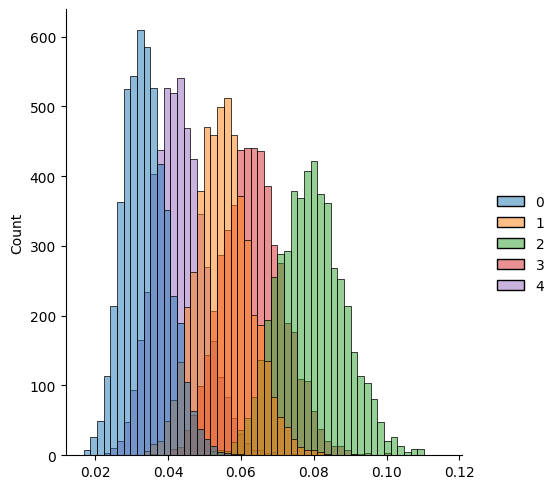

In [10]:
sns.displot(idata.posterior.occurances[0, :, :].values)

In [11]:
diff_1_vs_4 = (idata.posterior.occurances[:, :, 1] - idata.posterior.occurances[:, :, 4]).values.ravel()

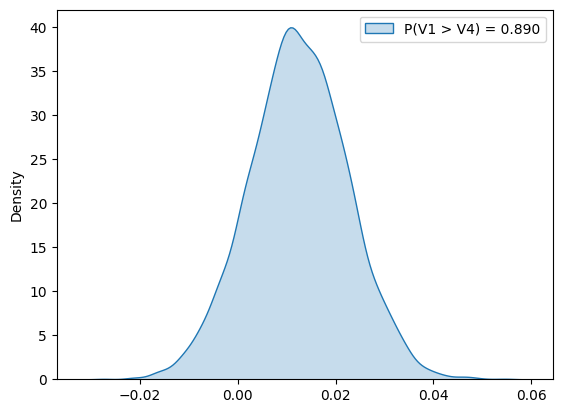

In [12]:
sns.kdeplot(diff_1_vs_4, fill=True, label=f"P(V1 > V4) = {(diff_1_vs_4 > 0).mean():.3f}")
plt.legend()
plt.show()

---
## Manual Bayesian update (Beta–Binomial)

For fast analytic updates the Beta–Binomial conjugacy is extremely handy. With a Beta(α, β) prior and k successes in n trials, the posterior is Beta(α + k, β + n − k). This leads to closed-form posterior moments and exact expressions for quantities like Probability of Superiority (PoS).

Say we have 10 heads from ten coinf flips, what is the probability to get get a head in the next flip?

Using Bayesian approach, where

$ \mathcal{H}$ - hypothesis, $\mathcal{D}$ - data

$P(\mathcal{H}) - prior$

$P(\mathcal{D} | \mathcal{H}) - likelihood $

$P(\mathcal{H} | \mathcal{D}) - posterior $

$$ P(\mathcal{H} | \mathcal{D}) \propto P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) $$

It can be shown that if

$$ P(\mathcal{H}) = {Beta}(p; \alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1} $$

$$ P(\mathcal{D} | \mathcal{H}) = {Binom}(p; k, n) = C_{n}^{k} p^{k} (1-p)^{n-k} $$

Then

\begin{split} P(\mathcal{H} | \mathcal{D}) & = P(p | k, n) = {Beta}(p; \alpha + k, \beta + n - k) \end{split}


Proof
$$ P(\mathcal{H} | \mathcal{D}) = \frac{P(\mathcal{D} | \mathcal{H}) P(\mathcal{H})}{P(\mathcal{D})} $$

$$ P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) = \biggl ( C_{n}^{k} \cdot p^{k} (1-p)^{n-k} \biggr ) \cdot \biggl ( \mathbf{\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}} \cdot p^{\alpha-1} (1-p)^{\beta-1} \biggr ) = C \cdot p^{\alpha+k-1}(1-p)^{\beta+n-k-1} $$

$$ P(\mathcal{D}) = \int_{0}^{1} P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) dp = C \cdot \int_{0}^{1} p^{\alpha+k-1} (1-p)^{\beta+n-k-1} dp = C \cdot B(\alpha+k, \beta+n-k)$$

Consequently combining those two equations, The Binomial Constant and the Prior Beta Constant are completely cancelled out

$$ P(\mathcal{H} | \mathcal{D}) = \frac{1}{B(\alpha+k, \beta+n-k)} p^{\alpha+k-1}(1-p)^{\beta+n-k-1} = {Beta}(p; \alpha + k, \beta + n - k) $$

End of Proof

In case of non-informative prior $ {Beta}(p; 1, 1) $ what basically given Uniform distribution of the prior - Beta function may be presented with a short binomial coefficient formula

$$ B(k+1, n-k+1) = \frac{Г(k+1)Г(n-k+1)}{Г(n+2)} = \frac{k!(n-k)!}{(n+1)!} = \frac{1}{(n+1)\; C_{n}^{k}} $$

In our case the posterior distribution is $ {Beta}(p; k + 1, n - k + 1) $

Hence we can build the predictive interval using this Beta distribution moments:

$$ \mu = \frac{\alpha}{\alpha + \beta} = \frac{k+1}{n+2} $$

This formula for $ \mu $ is also used as the Laplace sequence rule, which requires adding one positive and one negative observation to estimate the posterior probability distribution for a random sample.

Adding second moment

$$ \sigma^2 = {\frac {\alpha \beta }{(\alpha +\beta )^{2}(\alpha +\beta +1)}} = \frac{(k+1)(n-k+1)}{(n+2)^2(n+3)} $$

In [13]:
print(f"Hence 2 sigma predictive interval for 10/10 successful flips is {11/12:.2%} ± {2 * (11 / 12 ** 2 / 13) ** 0.5 :.2%}")

Hence 2 sigma predictive interval for 10/10 successful flips is 91.67% ± 15.33%


But it's not a Normal distribution, so it's not 95% condifence interval, we need to take Beta distribution quantile instead or calculate it precisely

In [14]:
from scipy import stats as sts

It's very close resemble the approxiamtion that we get using normal distibution quantile

In [15]:
sts.beta.ppf([0.05, 1.0], a=11, b=1)

array([0.76159581, 1.        ])

Another way is get that number analytically from the integral equation

$$ \int_{p_{crit}}^{1} (n+1) \cdot C_n^n \cdot p^n (1-p)^0 dp = 0.95 $$


$$ p_{crit} = \sqrt[n + 1]{0.05}$$

In [16]:
print(f"What makes it an easy computation: p is from [{0.05 ** (1/11) :.5f}, 1.0] and it fully coincides with the value from stats package")

What makes it an easy computation: p is from [0.76160, 1.0] and it fully coincides with the value from stats package


Criterion that is used for analytical model decision making in A/B experiment

$$ P(\lambda_B > \lambda_A) = \int_{p_B > p_A} P(p_A, p_B | \text{Data}) \, dp_A \, dp_B = \sum_{i=0}^{\alpha_B-1} \frac{B(\alpha_A+i, \beta_A+\beta_B)}{(\beta_B+i)B(1+i, \beta_B)B(\alpha_A, \beta_A)} $$

The formula is the result of applying a well-known mathematical identity that allows the cumulative probability of one Beta variable being less than another Beta variable to be expressed as a finite sum of terms involving the Beta function, rather than requiring complex numerical integration. This is why this formula is computationally efficient and preferred for exact Bayesian A/B calculations.

---
## Monte Carlo simulation

To compare stopping rules and power, the notebook includes a Monte Carlo harness. It simulates repeated experiments, applies frequentist sequential z-tests and several Bayesian stopping rules (naive PoS threshold, expected-loss stopping, and HDI+PoS combinations), and compares false positive rates and average stopping sample sizes.

In [17]:
from tqdm.notebook import tqdm

In [18]:
def min_sample_size(mde, mu, sigma, alpha=0.05, power=0.80) -> int:
    """
    Defines superiority one-side z-test sample size

    Args:
        mde: Relative uplift
        mu: Expected Value
        sigma: Squared Variance

    Returns:
        Required sample size to achieve the power
    """
    effect_size = abs(mde) * mu / sigma
    return int(((sts.norm.ppf(1 - alpha) + sts.norm.ppf(power)) / effect_size) ** 2)

In [19]:
p = 0.05
effect_size = p / (p * (1 - p)) ** 0.5
n = int(((sts.norm.ppf(1 - 0.05) + sts.norm.ppf(0.8)) / effect_size) ** 2)
print(n)

117


another way is simple approximate

In [20]:
# when you have all conversions zero
# upper bound is usually 3/n
# hence 3 / n = 0.05

print("Approx n: ", 3 / 0.05)

Approx n:  60.0


In [21]:
# or mathematically, if all conversions are zero
# (1-p)^n >= alpha, where alpha = 0.05
# we check if

int(np.log(0.05) / np.log(0.95))

58

In [22]:

def stops_at(is_significant: np.ndarray, sample_size: np.ndarray) -> int:
    """
    Determines the stopping sample size.

    This function identifies the first instance where the input
    condition is True and returns the corresponding sample size.

    Args:
        is_significant: A boolean array of the stop condition for each size
        sample_size: An array of sample sizes.

    Returns:
        The stopping sample size.

    Example:
        >>> detN([False, False, True, True], [50, 100, 150, 200])
        150
    """
    if len(is_significant) != len(sample_size):
        raise ValueError("Input arrays must have the same length.")
    w = np.where(is_significant)[0]
    return np.nan if len(w) == 0 else sample_size[w[0]]


In [23]:
n_iterations = 1000

def monte_carlo(
    effect_size: float=0.10,
    aa_test: bool=True,
    alpha: float=0.05,
    peeks: int = 1,
) -> pd.DataFrame:

    result = {
        'Frequentist': [],
        'Bayesian': [],
    }

    p = 0.20
    sigma = (p * (1 - p)) ** 0.5
    relative_effect = 0 if aa_test else effect_size

    N = min_sample_size(mde=effect_size, mu=p, sigma=sigma, alpha=alpha)
    n = int(N / peeks)

    print(f"Running {n_iterations} simulations with total sample size {N} that is achieved in {peeks} iterations of {n} size each")

    for seed in tqdm(range(n_iterations)):

        rng = np.random.default_rng(seed)
        binomial_samples = rng.binomial(n=n, p=p*(1+relative_effect), size=peeks)

        size = np.arange(n, N + 1, n)
        conversions = np.cumsum(binomial_samples)

        z_scores = [(success / trials - p) / np.sqrt(sigma ** 2 / trials) for success, trials in zip(conversions, size)]

        result['Frequentist'].append(stops_at(z_scores > sts.norm.ppf(1 - alpha), size))

        is_prob_high_enough = [sts.beta.cdf(p, a=1+success, b=1+trials-success) < alpha for success, trials in zip(conversions, size)]
        result['Bayesian'].append(stops_at(is_prob_high_enough, size))

    print("\n".join([
        f"Frequentist Rejected Rate: {np.mean(~np.isnan(result['Frequentist']))}",
        f"Frequentist Required Sample Size: {int(np.nanmean(result['Frequentist']))}",
        f"Bayesian Rejected Rate: {np.mean(~np.isnan(result['Bayesian']))}",
        f"Bayesian Required Sample Size: {int(np.nanmean(result['Bayesian']))}",
    ]))

In [24]:
monte_carlo(peeks=1, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 1 iterations of 2473 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.06
Frequentist Required Sample Size: 2473
Bayesian Rejected Rate: 0.06
Bayesian Required Sample Size: 2473


In [25]:
monte_carlo(peeks=5, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.126
Frequentist Required Sample Size: 1015
Bayesian Rejected Rate: 0.126
Bayesian Required Sample Size: 1015


In [26]:
monte_carlo(peeks=5, aa_test=False)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.855
Frequentist Required Sample Size: 1146
Bayesian Rejected Rate: 0.855
Bayesian Required Sample Size: 1146


That is a crucial observation and it points to a common misunderstanding about Bayesian A/B testing:

No, the standard Bayesian approach does not handle peeking (optional stopping) correctly by default if your goal is to control the frequentist Type I Error Rate (False Positive Rate).


While the Bayesian interpretation of results remains valid at any time, using a fixed threshold (e.g., stopping when $P(A > B) > 95\%$) and checking repeatedly will lead to an inflated False Positive Rate over many hypothetical experiments, just like in the frequentist approach.

What is NOT Affected (The Bayesian Advantage) The Posterior Distribution and the Probability of Superiority — is always valid, regardless of when you look at the data.

What IS Affected (The Peeking Problem) The problem arises when you use a fixed decision rule (like the $95\%$ threshold) to stop the test prematurely, based on the outcome.

The Myth: The common claim that "Bayesian testing is immune to peeking" is overstated. It is only immune in the sense that the posterior is always mathematically correct. It is not immune in the sense that it prevents the inflation of the frequentist Type I Error Rate when using a simple, fixed stopping threshold

#### How Bayesian Methods Truly Handle Peeking

 To safely peek and stop early in a Bayesian framework, you need to base your decision on a metric that incorporates the cost of a wrong decision, not just the probability of a difference.

 The correct Bayesian decision procedure is to stop when:
  - Expected Loss (EL) is Minimized: You stop the test when the Expected Loss of choosing the suboptimal variant falls below a commercially acceptable threshold $\epsilon$. This naturally accounts for uncertainty.13 If the posterior distributions are still wide (high uncertainty), the loss will be high, and you won't stop.

$$ E[L](p_a > p_b) = \int_0^1\int_0^1L(p_a,p_b, p_a > p_b)P(p_a|a,b,n_a,k_a)P(p_b|a,b,n_b,k_b)dp_adp_b $$

  - Sequential Designs (Like Multi-Armed Bandits): Techniques like Thompson Sampling are inherently Bayesian and sequential. They don't have a stopping rule based on error rates; they simply choose the best variant to show next based on the posterior, which naturally directs more traffic to the likely winner, making the experiment efficient without needing a fixed sample size.

### Example of Loss function applied

Define the Opportunity Loss Function $L(p_A, p_B)$, which is the regret you incur by choosing a variant that is not the best.If we Choose B, the loss only happens if $p_A > p_B$:$$L(\text{Choose B}) = \max(0, p_A - p_B)$$If we Choose A, the loss only happens if $p_B > p_A$:$$L(\text{Choose A}) = \max(0, p_B - p_A)$$

Using known properties and identities related to the Beta function, this complex double integral for Opportunity Loss function can be transformed into a closed-form summation:

$$ \text{EL}_A = \sum_{i=0}^{\alpha_B-1} \frac{\alpha_A \cdot B(\alpha_A+i+1, \beta_A+\beta_B)}{\beta_A \cdot B(i+1, \beta_B) \cdot B(\alpha_A, \beta_A)} - \sum_{i=0}^{\alpha_B-1} \frac{\alpha_B \cdot B(\alpha_A+i, \beta_A+\beta_B+1)}{(\beta_B+i) \cdot B(i+1, \beta_B) \cdot B(\alpha_A, \beta_A)} $$


The Formula for one-sample test is against benchmark $\lambda_0$:

$$\text{EL}_{\text{A}} = \lambda_0 \cdot I_{\lambda_0}(\alpha, \beta) - \frac{\alpha}{\alpha+\beta} \cdot I_{\lambda_0}(\alpha+1, \beta)$$

Python Implementation

In [27]:
from scipy.special import betainc
# betainc(a, b, x) calculates I_x(a, b)
# equal to sts.beta.cdf(x, a, b)

In [28]:
def calculate_opportunity_loss_one_sample(
    k: int,
    n: int,
    lambda_0: float,
    prior_alpha: int = 1,
    prior_beta: int = 1,
) -> float:
    """
    Calculates the Expected Loss of choosing the observed variant against
    a benchmark using the analytical formula. Absolute value of conversion loss.

    Args:
        k (int): Observed successes (conversions).
        n (int): Observed trials (visitors).
        prior_alpha (int): Prior alpha hyperparameter.
        prior_beta (int): Prior beta hyperparameter.
        lambda_benchmark (float): The fixed conversion rate benchmark (p_0).

    Returns:
        float: The Expected Loss of choosing the observed variant.
    """

    # Calculate Posterior Parameters (alpha and beta)
    alpha = k + prior_alpha
    beta = n - k + prior_beta

    # --- Term 1: Probability of Loss ---
    # Calculates I_lambda_bench(alpha, beta) = P(lambda_obs < lambda_bench)
    # The term is: lambda_bench * P(lambda_obs < lambda_bench)
    term1 = lambda_0 * betainc(alpha, beta, lambda_0)

    # --- Term 2: Weighted Expected Value ---
    # The fraction part: alpha / (alpha + beta) is the mean of Beta(alpha, beta)
    term2 = alpha / (alpha + beta) * betainc(alpha + 1, beta, lambda_0)

    return term1 - term2

Frequentist: We must collect $N$ samples to have an $1-\beta$ chance of detecting a $MDE$ difference with $\alpha$ error.

Bayesian: We will stop the test when the average potential loss incurred by choosing the sub-optimal variant is less than $\epsilon$ percentage points. By setting a small $\epsilon$, you ensure that the test continues until the potential future regret (loss) is extremely low, thus ensuring a high degree of confidence in the final decision while retaining the ability to peek safely

In [29]:
calculate_opportunity_loss_one_sample(50, 100, 0.9)

np.float64(0.4)

Adjust Monte Carlo procedure

In [30]:
def monte_carlo(
    effect_size: float=0.10,
    aa_test: bool=True,
    alpha: float=0.05,
    peeks: int = 1,
) -> pd.DataFrame:

    result = {
        'Frequentist': [],
        'Bayesian': [],
    }

    p = 0.20
    sigma = (p * (1 - p)) ** 0.5
    relative_effect = 0 if aa_test else effect_size

    N = min_sample_size(mde=effect_size, mu=p, sigma=sigma, alpha=alpha)
    n = int(N / peeks)

    print(f"Running {n_iterations} simulations with total sample size {N} that is achieved in {peeks} iterations of {n} size each")

    for seed in tqdm(range(n_iterations)):

        rng = np.random.default_rng(seed)
        binomial_samples = rng.binomial(n=n, p=p*(1+relative_effect), size=peeks)

        size = np.arange(n, N + 1, n)
        conversions = np.cumsum(binomial_samples)

        z_scores = [(success / trials - p) / np.sqrt(sigma ** 2 / trials) for success, trials in zip(conversions, size)]

        result['Frequentist'].append(stops_at(z_scores > sts.norm.ppf(1 - alpha), size))

        fraction = 1 / 10
        epsilon = fraction * effect_size * p

        is_prob_high_enough = [calculate_opportunity_loss_one_sample(success, trials, lambda_0=p) < epsilon for success, trials in zip(conversions, size)]
        result['Bayesian'].append(stops_at(is_prob_high_enough, size))

    print("\n".join([
        f"Frequentist Rejected Rate: {np.mean(~np.isnan(result['Frequentist']))}",
        f"Frequentist Required Sample Size: {int(np.nanmean(result['Frequentist']))}",
        f"Bayesian Rejected Rate: {np.mean(~np.isnan(result['Bayesian']))}",
        f"Bayesian Required Sample Size: {int(np.nanmean(result['Bayesian']))}",
    ]))

In [31]:
monte_carlo(peeks=30, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 30 iterations of 82 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.249
Frequentist Required Sample Size: 590
Bayesian Rejected Rate: 0.66
Bayesian Required Sample Size: 675


So, Loss Function doesn't save from Peeking problem, it's even more vulnerable than well-known p-value approach

We need another piece of the puzzle ...

### HDI

Highest Density Interval (sometimes called Highest Posterior Density Interval).

Definition: The $X\%$ HDI is the narrowest interval that contains $X\%$ of the probability mass of the posterior distribution.

Purpose: It is the Bayesian equivalent of the frequentist Confidence Interval (CI), but unlike the CI, you can state that there is an $X\%$ probability that the true parameter value (e.g., the true conversion rate) lies within the HDI.

The width of the HDI is simply (Upper Bound - Lower Bound). It is a direct and intuitive measure of the remaining uncertainty. A wide HDI means your posterior is flat and uncertain; a narrow HDI means your posterior is sharply peaked and confident.

Criterion | Function | Why it's Robust Against Peeking

Probability of Superiority (PoS) Measures how often $\lambda_B > \lambda_A$. Can be quickly crossed by early noise.

Expected Loss (EL) Measures Cost/Regret and requires the posterior to be tight enough that the potential loss is small. Mitigates peeking.

HDI Width Measures Precision/Uncertainty and requires the posterior to be narrow. Prevents stopping when uncertainty is high, regardless of the posterior mean.

In [32]:
import arviz as az

def calculate_beta_hdi_width(alpha, beta, hdi_prob=0.95, num_samples=10_000):
    """
    Calculates the Highest Density Interval (HDI) for a Beta distribution
    using Monte Carlo sampling and the arviz library.

    The calculation of the HDI is an iterative process that must find
    the interval boundary points where the probability density is equal,
    while the area between the points equals the target probability.

    Since Beta distribution is generally not symmetrical, the HDI bounds are not
    the same as the quantiles, which is why a specialized function is needed.

    Args:
        alpha (float): The posterior alpha parameter (k_obs + prior_alpha).
        beta (float): The posterior beta parameter (n_obs - k_obs + prior_beta).
        hdi_prob (float): The target probability mass (e.g., 0.95 for 95% HDI).
        num_samples (int): Number of samples to draw for Monte Carlo calculation.

    Returns:
        tuple: (lower_bound, upper_bound, width)
    """
    posterior_samples = sts.beta.rvs(a=alpha, b=beta, size=num_samples)

    # designed to work on posterior samples
    hdi_interval = az.hdi(posterior_samples, hdi_prob=hdi_prob)

    lower_bound = hdi_interval[0]
    upper_bound = hdi_interval[1]

    return upper_bound - lower_bound

So, let's update Monte Carlo once again

In [33]:
calculate_beta_hdi_width(100, 100, .99)

np.float64(0.180220886845953)

In [34]:
calculate_beta_hdi_width(100, 100, 0.8)

np.float64(0.08969208397745976)

In [35]:
def monte_carlo(
    effect_size: float=0.10,
    aa_test: bool=True,
    alpha: float=0.05,
    peeks: int = 1,
) -> pd.DataFrame:

    result = {
        'Frequentist': [],
        'Bayesian': [],
    }

    p = 0.20
    sigma = (p * (1 - p)) ** 0.5
    relative_effect = 0 if aa_test else effect_size

    N = min_sample_size(mde=effect_size, mu=p, sigma=sigma, alpha=alpha)
    n = int(N / peeks)

    print(f"Running {n_iterations} simulations with total sample size {N} that is achieved in {peeks} iterations of {n} size each")

    for seed in tqdm(range(n_iterations)):

        rng = np.random.default_rng(seed)
        binomial_samples = rng.binomial(n=n, p=p*(1+relative_effect), size=peeks)

        size = np.arange(n, N + 1, n)
        conversions = np.cumsum(binomial_samples)

        z_scores = [(success / trials - p) / np.sqrt(sigma ** 2 / trials) for success, trials in zip(conversions, size)]

        result['Frequentist'].append(stops_at(z_scores > sts.norm.ppf(1 - alpha), size))

        is_prob_high_enough = [
            # check if 95% of posterior distribution is narrow and lays in ± MDE
            (calculate_beta_hdi_width(1+success, 1+trials-success) < 2 * effect_size * p)
            # check if posterior distribution by 95% chance better
            and (sts.beta.cdf(p, a=1+success, b=1+trials-success) < alpha)
            for success, trials in zip(conversions, size)
        ]
        result['Bayesian'].append(stops_at(is_prob_high_enough, size))

    print("\n".join([
        f"Frequentist Rejected Rate: {np.mean(~np.isnan(result['Frequentist']))}",
        f"Frequentist Required Sample Size: {int(np.nanmean(result['Frequentist']))}",
        f"Bayesian Rejected Rate: {np.mean(~np.isnan(result['Bayesian']))}",
        f"Bayesian Required Sample Size: {int(np.nanmean(result['Bayesian']))}",
    ]))

In [36]:
monte_carlo(peeks=1, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 1 iterations of 2473 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.06
Frequentist Required Sample Size: 2473
Bayesian Rejected Rate: 0.06
Bayesian Required Sample Size: 2473


In [37]:
monte_carlo(peeks=10, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 10 iterations of 247 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.193
Frequentist Required Sample Size: 876
Bayesian Rejected Rate: 0.1
Bayesian Required Sample Size: 1924


In [38]:
monte_carlo(peeks=5, aa_test=False)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.855
Frequentist Required Sample Size: 1146
Bayesian Rejected Rate: 0.818
Bayesian Required Sample Size: 2035


HDI accompanied by Probability of Superiority is a good criterion, although very strict if you increase the required density for HDI from 80% above 95% and it hence requires much more sample size than Frequentist approach.

Combination of HDI and PoS checks makes the criterion less sesitive to peeking, however it's yet not fully immune.

---
## Conclusions & Practical Recommendations

- Use the posterior (and PoS) to *interpret* results, but prefer decision-theoretic stopping when making business choices: stop when the expected loss of choosing the suboptimal variant is below a tolerated threshold.
- Combining HDI width (precision) with PoS (direction) yields a conservative and intuitive stopping rule — but stricter HDI thresholds require larger samples.
- When many variants or small groups are present, hierarchical models provide safer estimates via partial pooling.
- If your goal is to guarantee frequentist properties (e.g., Type I control under peeking), design the sequential procedure explicitly (alpha-spending or adjusted thresholds) or run pre-planned group-sequential analyses.

Further experiments to try:
- Replace uniform priors with domain-informed priors when available.
- Explore Thompson Sampling for continuous allocation instead of fixed-sample stopping.
- Visualize posterior trajectories and stopping-rule tradeoffs across simulated peeks.

Thanks for reading — feel free to fork this notebook and experiment with your own traffic and loss thresholds.